In [1]:
import src.data_utils as dutils
import src.model_utils as mutils
import src.distributions as distr

import numpy as np
import torch
import src.distributions as dist
import matplotlib.pyplot as plt
import torch.nn as nn
from functools import partial
import tissue_2d as t2d

%load_ext autoreload
%autoreload 2

embedWindow(verbose=True): could not load ipyvtklink try:
> pip install ipyvtklink


### DAD on simple 1d location finding (https://arxiv.org/abs/2103.02438)

Training DAD design policy...


loss (asc) = 2.573228: 100%|██████████| 50/50 [00:00<00:00, 324.27it/s]

Trained DAD design policy.


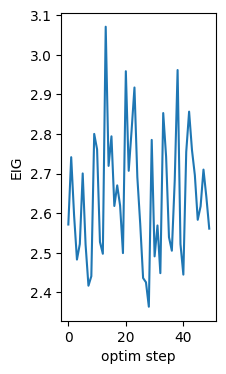

Example history: tensor([0.1655, 1.8113], grad_fn=<SelectBackward0>)


In [4]:
# design network
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,256),
            nn.ReLU(),
            nn.Linear(256,16)
        )
        self.design_dim = 1
        self.y_dim = 1
        self.repr_dim = 16
    def forward(self, xi,y):
        return self.model(torch.cat([xi,y],dim=1))

encoder = Encoder()
emitter = nn.Linear(16,1)
design_network = mutils.Design_Network(encoder,emitter)


# distributions
class Normal_prior(dist.Distr):
    def __init__(self, mu=torch.tensor([0.0]), sigma=torch.tensor([1.0])):
        super().__init__()
        self.distr = torch.distributions.Normal(mu, sigma)

    def sample(self,n):
        return self.distr.sample([n])

    def log_prob(self, thetas):
        return self.distr.log_prob(thetas)

class Squared_distance(dist.Conditional_Distr_multixi):
    def __init__(self, sigma=torch.tensor(0.5), m=torch.tensor(1e-4)):
        super().__init__()
        self.sigma = sigma
        self.m = m
        self.reparam_trick = True

    def sample(self,designs,thetas):
        mus = self.mu(thetas, designs)
        rvs = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))\
            .sample([thetas.shape[0]])
        out = mus + self.sigma * rvs
        return out.reshape((-1,1))
    
    def log_prob(self,ys,designs,thetas):
        mus = self.mu(thetas, designs)
        return torch.distributions.Normal(mus, self.sigma).log_prob(ys.reshape((-1))).reshape(-1,1)
    
    def mu(self, thetas, xis):
        return 1 / (self.m + torch.norm(thetas - xis, dim=1)**2)
        
prior = Normal_prior()
likelihood = Squared_distance()


# train design_network
T = 2
mutils.train_DAD_design_policy(
    T,
    prior,
    likelihood,
    design_network,
    n_steps=50,
    n_outer=100,
    L = 100,
    print_every=25,
    verbose = True)

# execute design
batch_size = 1
theta_0 = prior.sample(batch_size)
history_xi = []
history_y = []
design_network.reset_buffer(batch_size)
next_xi = torch.zeros((batch_size,design_network.design_dim))
next_y = torch.zeros((batch_size,design_network.y_dim))
for t in range(T):
    next_xi = design_network(next_xi, next_y)
    next_y = likelihood.sample(next_xi, theta_0)
    history_xi.append(next_xi.unsqueeze(1))
    history_y.append(next_y.unsqueeze(1))
history_xi = torch.cat(history_xi, dim=1)  # batch_size x T x design_dim
history_y = torch.cat(history_y, dim=1)    # batch_size x T x y_dim
print(f'Example history: {history_xi[0,:,0]}')

### 2d tissue slicing with interpolating affine grid


------- Iteration 1/4 -------
Finding best design...


  0%|          | 0/100 [00:00<?, ?it/s]/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
EIG = 1.499402: 100%|██████████| 100/100 [00:02<00:00, 35.11it/s]


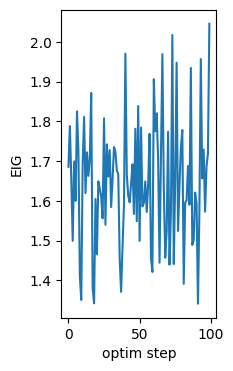

Executed design; best_eig: 2.045914, design_params: {'alpha': tensor(0.0288, requires_grad=True), 'y_intercept': tensor(-0.0159, requires_grad=True)}
Fitting posterior...


elbo = -4.890401: 100%|██████████| 1000/1000 [00:19<00:00, 51.56it/s]


Fitted posterior; thetas_MAP: tensor([[1.1649, 0.0659, 0.0906, 1.3184]])
Plotting results...
0.8187527


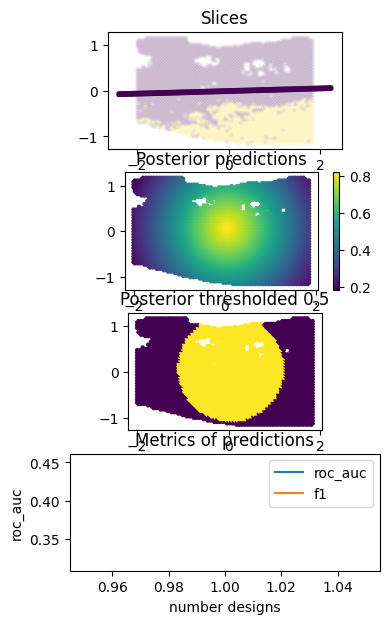

Plotted results.

------- Iteration 2/4 -------
Finding best design...


  0%|          | 0/100 [00:00<?, ?it/s]/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
EIG = 0.171216: 100%|██████████| 100/100 [00:02<00:00, 34.60it/s]


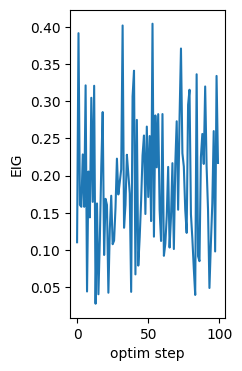

Executed design; best_eig: 0.216977, design_params: {'alpha': tensor(0.0346, requires_grad=True), 'y_intercept': tensor(-0.0125, requires_grad=True)}
Fitting posterior...


elbo = -0.118179: 100%|██████████| 1000/1000 [00:19<00:00, 50.66it/s]


Fitted posterior; thetas_MAP: tensor([[ 0.9263, -0.0016,  0.1027,  1.4959]])
Plotting results...
0.7967573


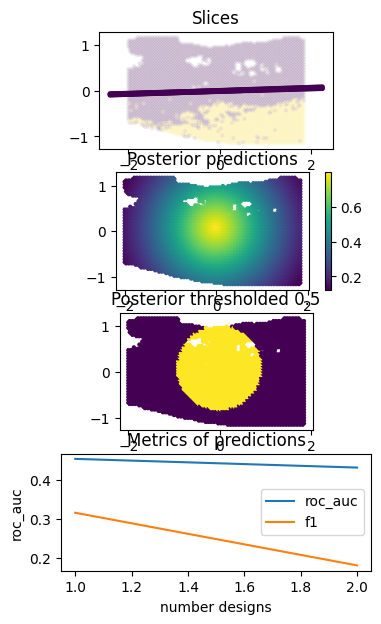

Plotted results.

------- Iteration 3/4 -------
Finding best design...


  0%|          | 0/100 [00:00<?, ?it/s]/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
EIG = 0.033961: 100%|██████████| 100/100 [00:02<00:00, 35.27it/s]


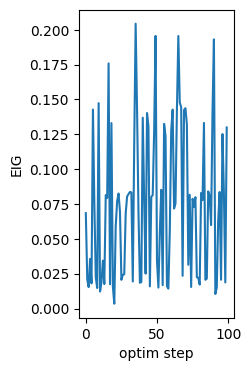

Executed design; best_eig: 0.129902, design_params: {'alpha': tensor(0.0366, requires_grad=True), 'y_intercept': tensor(-0.0143, requires_grad=True)}
Fitting posterior...


elbo = -0.102639: 100%|██████████| 1000/1000 [00:19<00:00, 52.20it/s]


Fitted posterior; thetas_MAP: tensor([[ 0.8969, -0.3083,  0.2143,  1.5836]])
Plotting results...
0.7998031


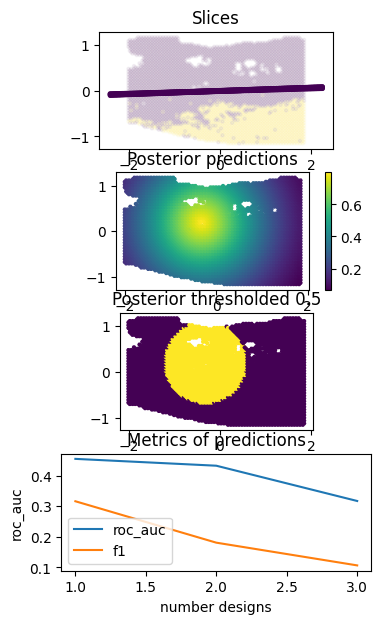

Plotted results.

------- Iteration 4/4 -------
Finding best design...


  0%|          | 0/100 [00:00<?, ?it/s]/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
EIG = -0.008622: 100%|██████████| 100/100 [00:02<00:00, 35.28it/s]


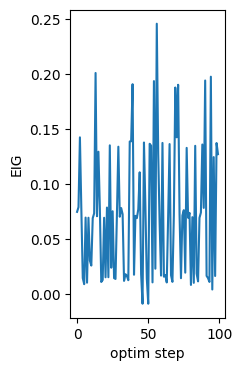

Executed design; best_eig: 0.127150, design_params: {'alpha': tensor(0.0354, requires_grad=True), 'y_intercept': tensor(-0.0091, requires_grad=True)}
Fitting posterior...


elbo = -1.346577: 100%|██████████| 1000/1000 [00:19<00:00, 50.54it/s]


Fitted posterior; thetas_MAP: tensor([[0.8490, 0.1614, 0.1656, 1.6057]])
Plotting results...
0.79134834


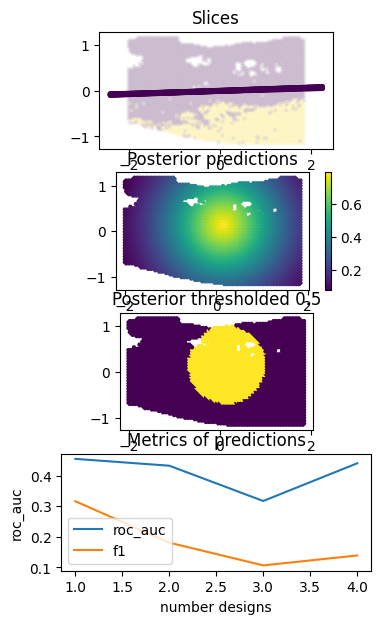

Plotted results.


In [7]:
# data
datamodule = t2d.Prostate_cancer_2d()
X,y = datamodule.get_data()
tissue = t2d.Tissue_continuous(X, y, slice_radius = 1)
torch.autograd.set_detect_anomaly(True)

# distributions
r_prior = torch.tensor([3.0])
mu = torch.tensor([torch.log(r_prior),0.,0.,0.])
std = torch.tensor([1.,10.,10.,1.])
prior = t2d.Circle_prior(mu=mu,std=std)
predictive = t2d.Circle_predictive()

# optimization
eig_calc_method = partial(mutils.eig_PCE, n_outer=50, n_inner=20)
eig_optim_method = partial(mutils.eig_cont_optim, n_steps=100)
varinf_method = partial(mutils.variational_inference, n_steps=1000)
n_designs = 4
optim_args = {
    'alpha': ('minmax', -torch.pi, torch.pi),
    'y_intercept': ('minmax', -1, 1),
}

experiment, thetas_MAP, metric_values, metric_names = mutils.OED_fit(
    tissue, prior,predictive,n_designs,eig_calc_method,eig_optim_method,varinf_method,
    print_every=50, verbose=True,
)